Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [6]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [7]:
#новости
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [8]:
#пользователи
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


## Векторные представления новостей

In [9]:
from gensim.corpora.dictionary import Dictionary

In [10]:
#предобработка текстов
import re
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel


import pymorphy2  

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Елена\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
stopword_ru = stopwords.words('russian')

morph = pymorphy2.MorphAnalyzer()
len(stopword_ru)

151

In [12]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [13]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [14]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 1min 2s


In [15]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 6min 10s


In [16]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [17]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 1min 9s


In [18]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

In [19]:
# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [20]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(2, 0.21655843),
 (4, 0.30421707),
 (11, 0.38913438),
 (13, 0.04374681),
 (21, 0.028446546)]

In [21]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: сша который это американский исследование свой год
topic_1: nn государственный снижение знаменитый федеральный депутат корпус
topic_2: статья год женщина млн препарат следствие стать
topic_3: решение суд конкурс nn нарушение компания договор
topic_4: это год который мочь всё рост весь
topic_5: район пострадать рак автомобиль снижение берег образоваться
topic_6: украина эксперимент сотрудник чиновник восток задержать убийство
topic_7: египет памятник азия лекарство свидетель грузия городской
topic_8: россия страна российский который nn военный президент
topic_9: фонд научный год это который журнал технология
topic_10: пациент экипаж поверхность миссия врач час обнаружить
topic_11: китай стать китайский год nn место японский
topic_12: правительство закон законопроект доход президент год который
topic_13: год это который проект млрд также новый
topic_14: квартира рейс аэропорт мэй египетский миллиардер тур
topic_15: банк рубль уголовный год ук приговор актив
topic_16: год который

In [22]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [23]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.024689,0.238034,0.011840,0.106497,0.000000,0.0,0.0,0.0,0.151469,...,0.352024,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,4896,0.000000,0.091514,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,4897,0.000000,0.000000,0.216537,0.000000,0.304165,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.028447,0.0,0.0,0.0
3,4898,0.000000,0.000000,0.237836,0.000000,0.575959,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,4899,0.184199,0.297355,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.280809,...,0.000000,0.0,0.036194,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


## Векторные представления пользователей

In [24]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [73]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [74]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding_mean(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [75]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [76]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [77]:
get_user_embedding_median(user_articles_list)

array([0.08759553, 0.        , 0.        , 0.05906407, 0.17548501,
       0.        , 0.        , 0.        , 0.11964851, 0.01714635,
       0.        , 0.        , 0.        , 0.06863488, 0.        ,
       0.        , 0.05563764, 0.        , 0.        , 0.01566246,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [78]:
#получим эмбединги для всех пользователей (медианный подход)
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.031005,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.184279,...,0.000000,0.041542,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
1,u108690,0.039932,0.009153,0.035169,0.000000,0.271514,0.00000,0.097734,0.0,0.137746,...,0.006206,0.153475,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.018543
2,u108339,0.027750,0.000000,0.022954,0.028516,0.101435,0.01958,0.030262,0.0,0.118141,...,0.000000,0.166780,0.0,0.0,0.024818,0.0,0.0,0.0,0.0,0.009850


In [79]:
#загрузим разметку
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [80]:
X_median = pd.merge(user_embeddings_median, target, 'left')
X_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.031005,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.184279,...,0.041542,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0
1,u108690,0.039932,0.009153,0.035169,0.000000,0.271514,0.00000,0.097734,0.0,0.137746,...,0.153475,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.018543,1
2,u108339,0.027750,0.000000,0.022954,0.028516,0.101435,0.01958,0.030262,0.0,0.118141,...,0.166780,0.0,0.0,0.024818,0.0,0.0,0.0,0.0,0.009850,1


In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [82]:
#разделим данные на train/test
X_train_median, X_test_median, y_train_median, y_test_median = train_test_split(X_median[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_median['churn'], random_state=0)

In [83]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train_median, y_train_median)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [84]:
#наши прогнозы для тестовой выборки
preds_median = logreg.predict_proba(X_test_median)[:, 1]
preds_median[:10]

array([0.08283385, 0.06428567, 0.38453012, 0.66674998, 0.00514134,
       0.01225884, 0.02295402, 0.0652719 , 0.10778419, 0.08322053])

In [85]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

## Рассчитаем Precision, Recall, F-score (median)

In [86]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_test_median, preds_median)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
# locate the index of the largest f score
ix_median = np.argmax(fscore_median)
print('Best Threshold_median=%f, F-Score_median=%.3f, Precision_median=%.3f, Recall_median=%.3f' % (thresholds_median[ix_median], 
                                                                        fscore_median[ix_median],
                                                                        precision_median[ix_median],
                                                                        recall_median[ix_median]))

Best Threshold_median=0.355734, F-Score_median=0.807, Precision_median=0.805, Recall_median=0.808


In [87]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1707   48]
 [  48  197]]


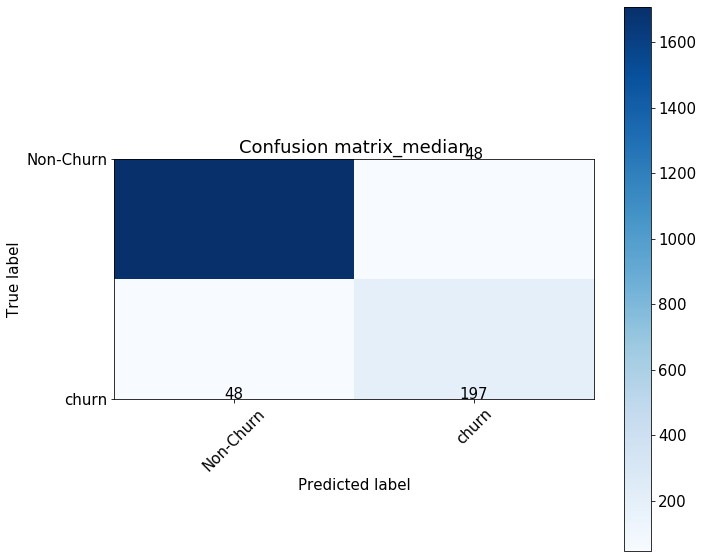

In [88]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_median, preds_median>thresholds_median[ix_median])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix_median')
plt.savefig("conf_matrix_median.png")
plt.show()

In [89]:
roc_auc_median = roc_auc_score(y_test_median, preds_median)
roc_auc_median

0.9828687714402

## c применением np.mean

In [90]:
#получим эмбединги для всех пользователей (mean подход)
user_embeddings_mean = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_mean(x), 1)])
user_embeddings_mean.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_mean['uid'] = users['uid'].values
user_embeddings_mean = user_embeddings_mean[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.050295,0.063307,0.036606,0.017318,0.042249,0.007940,0.026715,0.014226,0.161458,...,0.003094,0.124779,0.019539,0.000000,0.039533,0.020217,0.0,0.006630,0.002392,0.076766
1,u108690,0.070431,0.016084,0.031630,0.010650,0.223814,0.010612,0.099317,0.007297,0.180067,...,0.007928,0.183444,0.000000,0.000000,0.007927,0.002962,0.0,0.000000,0.000000,0.018191
2,u108339,0.028557,0.011751,0.038937,0.027337,0.112752,0.037030,0.057688,0.005094,0.180655,...,0.016437,0.151586,0.000000,0.001902,0.037866,0.000000,0.0,0.002019,0.000000,0.014288


In [91]:
X_mean = pd.merge(user_embeddings_mean, target, 'left')
X_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.050295,0.063307,0.036606,0.017318,0.042249,0.007940,0.026715,0.014226,0.161458,...,0.124779,0.019539,0.000000,0.039533,0.020217,0.0,0.006630,0.002392,0.076766,0
1,u108690,0.070431,0.016084,0.031630,0.010650,0.223814,0.010612,0.099317,0.007297,0.180067,...,0.183444,0.000000,0.000000,0.007927,0.002962,0.0,0.000000,0.000000,0.018191,1
2,u108339,0.028557,0.011751,0.038937,0.027337,0.112752,0.037030,0.057688,0.005094,0.180655,...,0.151586,0.000000,0.001902,0.037866,0.000000,0.0,0.002019,0.000000,0.014288,1


In [92]:
#разделим данные на train/test
X_train_mean, X_test_mean, y_train_mean, y_test_mean = train_test_split(X_mean[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_mean['churn'], random_state=0)

In [93]:
#обучим 
logreg.fit(X_train_mean, y_train_mean)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [94]:
#наши прогнозы для тестовой выборки
preds_mean = logreg.predict_proba(X_test_mean)[:, 1]
preds_mean[:10]

array([0.07883674, 0.10726962, 0.32311952, 0.42966284, 0.00910124,
       0.02005137, 0.0952527 , 0.06851803, 0.20845292, 0.0893959 ])

## Рассчитаем Precision, Recall, F-score (mean)

In [95]:
precision_mean, recall_mean, thresholds_mean = precision_recall_curve(y_test_mean, preds_mean)
fscore_mean = (2 * precision_mean * recall_mean) / (precision_mean + recall_mean)
# locate the index of the largest f score
ix_mean = np.argmax(fscore_mean)
print('Best Threshold_mean=%f, F-Score_mean=%.3f, Precision_mean=%.3f, Recall_mean=%.3f' % (thresholds_mean[ix_mean], 
                                                                        fscore_mean[ix_mean],
                                                                        precision_mean[ix_mean],
                                                                        recall_mean[ix_mean]))

Best Threshold_mean=0.289653, F-Score_mean=0.770, Precision_mean=0.716, Recall_mean=0.833


Confusion matrix, without normalization
[[1674   81]
 [  42  203]]


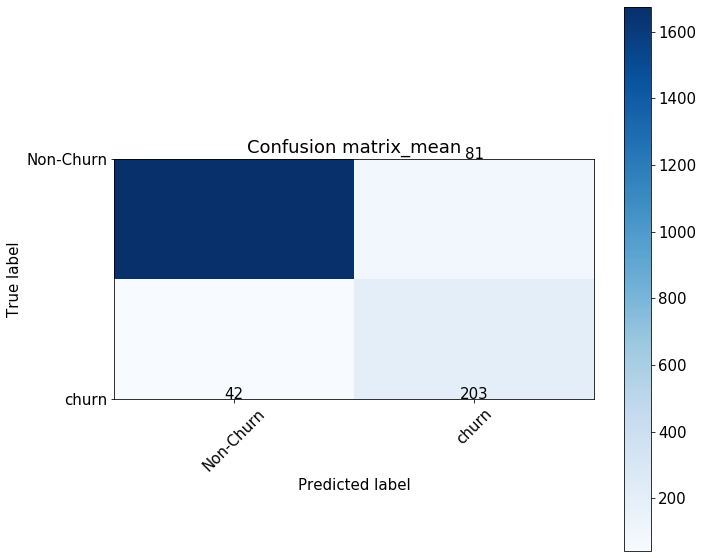

In [96]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_mean, preds_mean>thresholds_mean[ix_mean])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix_mean')
plt.savefig("conf_matrix_mean.png")
plt.show()

In [97]:
roc_auc_mean = roc_auc_score(y_test_mean, preds_mean)
roc_auc_mean

0.9773824059538344

## c применением np.max

In [98]:
#получим эмбединги для всех пользователей (max подход)
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.267737,0.180398,0.186983,0.103907,0.197556,0.047643,0.128026,0.059647,0.289589,...,0.018565,0.417953,0.117236,0.000000,0.119345,0.109368,0.0,0.039780,0.014354,0.400510
1,u108690,0.215505,0.058037,0.075347,0.039955,0.368804,0.063672,0.179082,0.043783,0.486130,...,0.019729,0.451483,0.000000,0.000000,0.032176,0.017774,0.0,0.000000,0.000000,0.038396
2,u108339,0.071107,0.056554,0.125553,0.057883,0.205915,0.097866,0.174912,0.015393,0.404156,...,0.068680,0.329278,0.000000,0.011413,0.105468,0.000000,0.0,0.012112,0.000000,0.037758


In [99]:
X_max = pd.merge(user_embeddings_max, target, 'left')
X_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.267737,0.180398,0.186983,0.103907,0.197556,0.047643,0.128026,0.059647,0.289589,...,0.417953,0.117236,0.000000,0.119345,0.109368,0.0,0.039780,0.014354,0.400510,0
1,u108690,0.215505,0.058037,0.075347,0.039955,0.368804,0.063672,0.179082,0.043783,0.486130,...,0.451483,0.000000,0.000000,0.032176,0.017774,0.0,0.000000,0.000000,0.038396,1
2,u108339,0.071107,0.056554,0.125553,0.057883,0.205915,0.097866,0.174912,0.015393,0.404156,...,0.329278,0.000000,0.011413,0.105468,0.000000,0.0,0.012112,0.000000,0.037758,1


In [100]:
#разделим данные на train/test
X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X_max[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_max['churn'], random_state=0)

In [101]:
#обучим 
logreg.fit(X_train_max, y_train_max)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [102]:
#наши прогнозы для тестовой выборки
preds_max = logreg.predict_proba(X_test_max)[:, 1]
preds_max[:10]

array([0.07640924, 0.04813931, 0.6401688 , 0.23601527, 0.00325157,
       0.01528302, 0.11413386, 0.0074117 , 0.00670942, 0.10976006])

## Рассчитаем Precision, Recall, F-score (max)

In [103]:
precision_max, recall_max, thresholds_max = precision_recall_curve(y_test_max, preds_max)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix_max = np.argmax(fscore_max)
print('Best Threshold_max=%f, F-Score_max=%.3f, Precision_max=%.3f, Recall_max=%.3f' % (thresholds_max[ix_max], 
                                                                        fscore_max[ix_max],
                                                                        precision_max[ix_max],
                                                                        recall_max[ix_max]))

Best Threshold_max=0.417089, F-Score_max=0.805, Precision_max=0.847, Recall_max=0.767


Confusion matrix, without normalization
[[1721   34]
 [  58  187]]


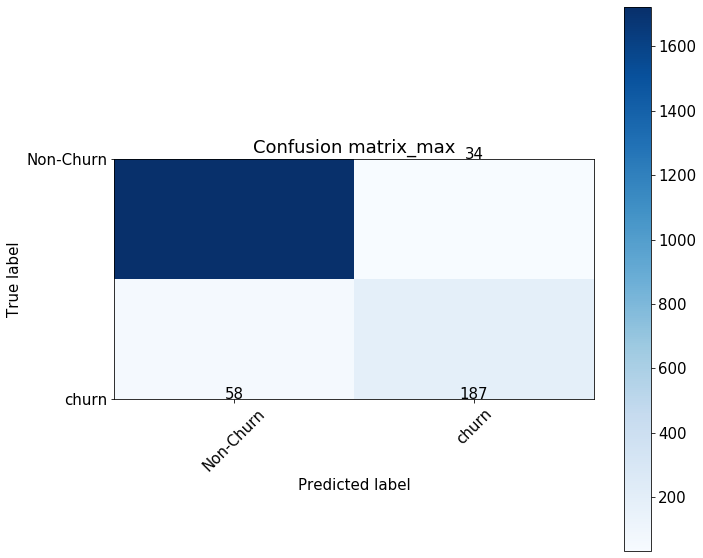

In [104]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_max, preds_max>thresholds_max[ix_max])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix_max')
plt.savefig("conf_matrix_max.png")
plt.show()

In [105]:
roc_auc_max = roc_auc_score(y_test_max, preds_max)
roc_auc_max

0.9793150764579336

In [110]:
a = {'roc_auc' : [roc_auc_mean, roc_auc_median, roc_auc_max ],
     'Precision' : [precision_mean[ix_mean], precision_median[ix_median], precision_max[ix_max]],
     'Recall' : [recall_mean[ix_mean], recall_median[ix_median], recall_max[ix_max]],
     'f-score' : [fscore_mean[ix_mean], fscore_median[ix_median], fscore_max[ix_max]]
    }

df = pd.DataFrame(a)
df.round(3)

,roc_auc,Precision,Recall,f-score
0,0.977,0.716,0.833,0.770
1,0.983,0.805,0.808,0.807
2,0.979,0.847,0.767,0.805


In [111]:
df.index = ['mean', 'median', 'max']

In [112]:
df.round(3)

,roc_auc,Precision,Recall,f-score
mean,0.977,0.716,0.833,0.770
median,0.983,0.805,0.808,0.807
max,0.979,0.847,0.767,0.805


Наилучший ээфект дала медианная мера. roc-auc - максимальный, Precision и Recall более сбалансированы, поэтому f-score максимальный. Скорее всего медиана дала наилучший результат, так как она не так восприимчива к выбросам. Но в любом случае выбор того или иного метода зависит от постановки задачи бизнесом.